In [1]:
from training.run import Run
from evaluation import metrics, plots

In [2]:
def make_config(model_name):
    return {'model_name': model_name, 'features': 'all', 'train_size': 40, 
                  'test_size': 20, 'pca': 2, 'dataset': 'breast_cancer', 'seed': 10598}

In [3]:
def test(config):
    run = Run(config)
    metrics.print_metrics(run)
    plots.plot_roc_curve(run)
    plots.plot_scores(run)

## Scikit-learn SVM

In [4]:
config = make_config('sklearn_svm')

Total training time: 2.403937578201294 s
Total testing time: 0.0008208751678466797 s
Printing metrics for run at /home/alex/qsvm_jet_tagging/results/009.
	Testing accuracy = 1.0
	support = 5/40
	Training accuracy = 0.975
	Training time = 2.403937578201294
	Testing time = 0.0008208751678466797
Saved roc curve plot at /home/alex/qsvm_jet_tagging/results/009/roc_curve.png.


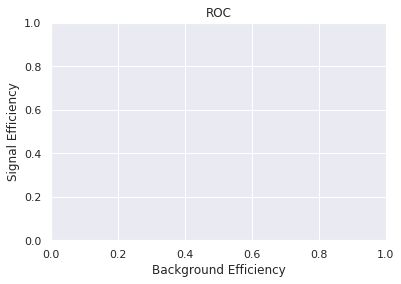

Saved score plot at /home/alex/qsvm_jet_tagging/results/009/scores.png.


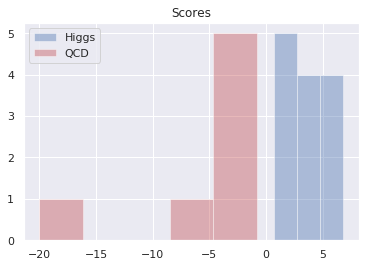

In [5]:
test(config)

## Qiskit Classical SVM

In [6]:
config = make_config('svm_classical')

Total training time: 0.015485525131225586 s
Total testing time: 0.0010504722595214844 s
Printing metrics for run at /home/alex/qsvm_jet_tagging/results/010.
	Testing accuracy = 0.85
	support = 10/40
	Training accuracy = 0.875
	Training time = 0.015485525131225586
	Testing time = 0.0010504722595214844
Saved roc curve plot at /home/alex/qsvm_jet_tagging/results/010/roc_curve.png.


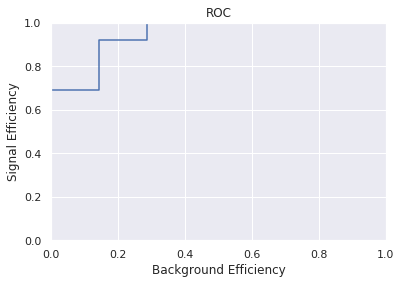

Saved score plot at /home/alex/qsvm_jet_tagging/results/010/scores.png.


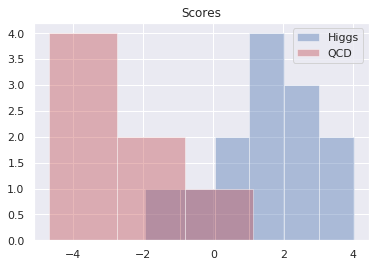

In [7]:
test(config)

## Qiskit QSVM Kernel

In [8]:
config = make_config('qsvm_kernel')

Total training time: 25.856383085250854 s
Total testing time: 24.137038469314575 s
Printing metrics for run at /home/alex/qsvm_jet_tagging/results/011.
	Testing accuracy = 0.85
	support = 38/40
	Training accuracy = 0.825
	Training time = 25.856383085250854
	Testing time = 24.137038469314575
Saved roc curve plot at /home/alex/qsvm_jet_tagging/results/011/roc_curve.png.


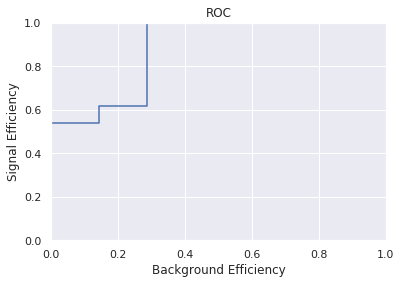

Saved score plot at /home/alex/qsvm_jet_tagging/results/011/scores.png.


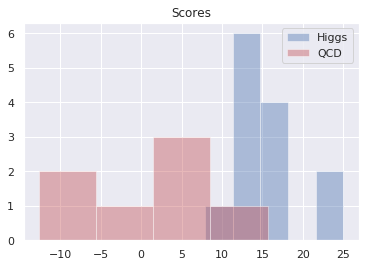

In [9]:
test(config)

## Qiskit QSVM Variational

In [10]:
config = make_config('qsvm_variational')

Total training time: 186.22539901733398 s
Total testing time: 0.6023621559143066 s
Printing metrics for run at /home/alex/qsvm_jet_tagging/results/012.
	Testing accuracy = 0.9
	Training accuracy = 0.85
	Training time = 186.22539901733398
	Testing time = 0.6023621559143066
Saved roc curve plot at /home/alex/qsvm_jet_tagging/results/012/roc_curve.png.


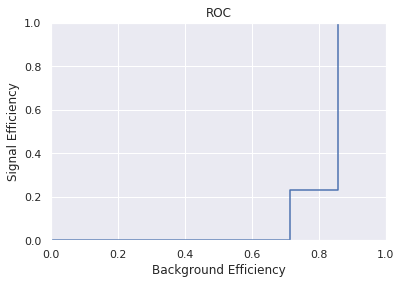

Saved score plot at /home/alex/qsvm_jet_tagging/results/012/scores.png.


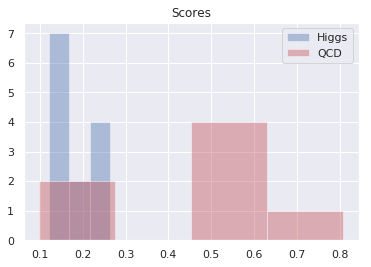

In [11]:
test(config)

# Tutorial

In [12]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from qiskit_aqua.algorithms import QSVMKernel
from qiskit_aqua.components.feature_maps import SecondOrderExpansion
from qiskit import Aer
from qiskit_aqua import QuantumInstance

In [13]:
seed = 10598

In [14]:
def Breast_cancer(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B']
    data, target = datasets.load_breast_cancer(True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=test_size, train_size=training_size, random_state=seed, stratify=target)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n, random_state=seed).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    # NOTE: Modified from tutorial to fit based on train data only.
    minmax_scale = MinMaxScaler((-1, 1)).fit(sample_train)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)
    
    training_input = {key: sample_train[label_train == k] for k, key in enumerate(class_labels)}
    test_input = {key: sample_test[label_test == k] for k, key in enumerate(class_labels)}
    if PLOT_DATA:
        for k in range(0, 2):
            plt.scatter(sample_train[label_train == k, 0],
                        sample_train[label_train == k, 1])

        plt.title("PCA dim. reduced Breast cancer dataset")
        plt.show()

    return sample_test, label_test, training_input, test_input, class_labels

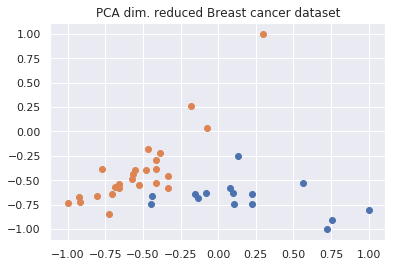

In [15]:
sample_test, label_test, training_input, test_input, class_labels = Breast_cancer(training_size=40,
                                                                       test_size=20,
                                                                       n=2,
                                                                       PLOT_DATA=True)

In [16]:
feature_map = SecondOrderExpansion(num_qubits=2, depth=2, entanglement='linear')
qsvm = QSVMKernel(feature_map, training_input, test_input)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed=seed, seed_mapper=seed)

result = qsvm.run(quantum_instance)
print(f'testing size: {len(test_input["A"])+len(test_input["B"])}')
print("testing success ratio: ", result['testing_accuracy'])
      

testing size: 20
testing success ratio:  0.8


In [17]:
from sklearn.utils import shuffle

In [18]:
def predict(X, y, seed):
    index = np.arange(y.shape[0])
    X, y, index = shuffle(X, y, index, random_state=seed)
    y_hat = qsvm.predict(X)
    m = index.argsort()
    X = X[m]
    y = y[m]
    y_hat = y_hat[m]
    print('predict:')
    print('\t X:')
    print(X)
    print('\t y:')
    print(y_hat)
    print('\t y_expected:')
    print(y)
    print('testing_accuracy: ', np.sum(y_hat==y)/y_hat.shape[0])
    

In [19]:
predict(sample_test, label_test, seed=10598)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.9


In [20]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.8


In [21]:
predict(sample_test, label_test, seed=28347)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.85


In [22]:
predict(sample_test, label_test, seed=153)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.9


In [23]:
predict(sample_test, label_test, seed=100)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.85


In [24]:
predict(sample_test, label_test, seed=0)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.8


In [25]:
predict(sample_test, label_test, seed=1)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.85


In [26]:
predict(sample_test, label_test, seed=2)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.85


In [27]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.8


In [28]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.8


In [29]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.8


In [30]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.8


In [31]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.8


In [32]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.8


In [33]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.8


In [34]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.8


In [35]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.40228326 -0.7214732 ]
 [-0.53509116 -0.40201803]
 [-0.33376072 -0.68603366]
 [-0.59945354 -0.59236367]
 [-0.87923229 -0.62233004]
 [-0.4483323  -0.43329109]
 [-0.40589212 -0.49802939]
 [-0.02916742 -0.3295579 ]
 [-0.79785325 -0.596832  ]
 [-0.77625395 -0.46040095]
 [-0.45196765 -0.88445033]
 [-0.59609731 -0.5375037 ]
 [-0.64181417 -0.67902307]
 [-0.84130492 -0.52492474]
 [ 0.85471618 -1.17005751]
 [-0.55292781 -0.69543489]
 [ 0.1999238  -0.37738835]
 [-0.82968685 -0.76651487]
 [-0.86031117 -0.46872192]
 [ 0.01626329 -0.77182174]]
	 y:
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0]
	 y_expected:
[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0]
testing_accuracy:  0.8
